# Comparing outcomes of mean simulations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import scipy.sparse as sparse
import itertools
import numpy as np
import scipy.stats as stats
from scipy.special import kl_div
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time

/tmp/ipykernel_13232/1976549207.py:13: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ubuntu/Github/memento/')
import memento
import memento.auxillary.simulate as simulate

In [4]:
data_path = '/home/ubuntu/Data/'

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

### Read fish estimates

In [7]:
smfish_estimates = np.load(data_path + 'smfish/smfish_estimates.npz')

In [8]:
smfish_genes = list(smfish_estimates['mean_genes'])
smfish_mean = smfish_estimates['mean']

In [9]:
dropseq_genes = sc.read_h5ad(data_path + 'smfish/filtered_dropseq.h5ad').var.index.tolist()
smfish_gene_idxs = [dropseq_genes.index(smg) for smg in smfish_genes]
gapdh_idx = dropseq_genes.index('GAPDH')

In [10]:
len(smfish_genes)

21

### Plotting

In [11]:
def concordance(x, y, log=True):
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    
    return cond.sum(), stats.pearsonr(a, b)[0]
    cmat = np.cov(a, b)
    return cond.sum(), 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

In [12]:
def plot_curve(x, y, data, ax, marker, color, markersize, linestyle='-', label=''):
    
    agg_data = data.groupby(x)[y].agg(['mean', 'std', 'count'])
    x_data = agg_data.index
    y_data = agg_data['mean'].values
    y_err = agg_data['std']/np.sqrt(agg_data['count'])
    
    ax.plot(np.arange(x_data.shape[0]), y_data, marker=marker, color=color, markersize=markersize, linestyle=linestyle, label=label)
    ax.fill_between(np.arange(x_data.shape[0]), y_data-y_err, y_data+y_err, alpha=0.2, color=color)
    ax.set_xticks(np.arange(x_data.shape[0]), x_data)

In [13]:
# Convenient to run this here
!source activate mementocxg ; python /home/ubuntu/Github/scrna-parameter-estimation/smfish/mean/smfish_mean_estimation.py

In [15]:

means = np.load(data_path + 'smfish/mean/sample_means.npz')['means']
meta = pd.read_csv(data_path + 'smfish/mean/sample_metadata.csv')
results = meta.copy()

# scale so that GAPDH has expr 1, to follow convention
means = means/means[:, gapdh_idx].reshape(-1,1)

correlations = []
counts = []
for i in range(means.shape[0]):
    
    valid_count, c = concordance(smfish_mean, means[i][smfish_gene_idxs])
    correlations.append(c)
    counts.append(valid_count)
results['correlation'] = correlations
results['valid_count'] = counts

# plt.savefig('mean_fish.pdf', bbox_inches='tight')

/tmp/ipykernel_13232/3914353887.py:5: RuntimeWarning: divide by zero encountered in log
  b = np.log(y)


### Permutation pvalue of corrrelation using all cells

In [41]:
n = means[-2, smfish_gene_idxs]
m = means[-1, smfish_gene_idxs]

n_null = np.zeros(50000)
m_null = np.zeros(50000)

for p in range(50000):
    
    order1 = np.random.choice(n.shape[0], size=n.shape[0],replace=False)
    order2 = np.random.choice(n.shape[0], size=n.shape[0],replace=False)
    
    n_null[p] = stats.pearsonr(np.log(smfish_mean[order1]), np.log(n[order2]))[0]
    m_null[p] = stats.pearsonr(np.log(smfish_mean[order1]), np.log(m[order2]))[0]

In [33]:
n_stat = stats.pearsonr(np.log(smfish_mean), np.log(n))[0]
m_stat = stats.pearsonr(np.log(smfish_mean), np.log(m))[0]

In [ ]:
n_null[n_null < n_stat].mean()

In [48]:
(n_null > n_stat).mean()

0.00078

In [46]:
(m_null > m_stat).mean()

0.00072

In [35]:
n_stat

0.651723729289404

In [23]:
sample

array([ 5, 16,  6, 10,  3, 11,  2, 15, 13,  8,  0,  4, 17,  1,  9, 14,  7,
       12, 19, 20, 18])

In [29]:
# sns.kdeplot(results.query('method == "hypergeometric" & num_cell == 10').correlation)
# sns.kdeplot(results.query('method == "hypergeometric" & num_cell == 3000').correlation)


In [30]:
results.groupby(['num_cell', 'method'])['correlation'].mean()

num_cell  method        
10        hypergeometric    0.569059
          naive             0.549781
20        hypergeometric    0.576116
          naive             0.552799
30        hypergeometric    0.594919
          naive             0.580366
50        hypergeometric    0.608118
          naive             0.590593
100       hypergeometric    0.614997
          naive             0.601412
5000      hypergeometric    0.651003
          naive             0.650253
8000      hypergeometric    0.652863
          naive             0.651724
Name: correlation, dtype: float64

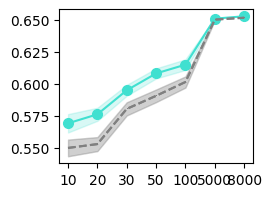

In [31]:
valid_results = results#.query('valid_count > 10')
fig, ax = plt.subplots(figsize=(2.5,2))


plot_curve('num_cell', 'correlation', 
           data=valid_results\
            .query('method == "hypergeometric"'),
           ax=ax, 
           color='turquoise',
           marker='o', 
           markersize=7)

plot_curve('num_cell', 'correlation', 
           data=valid_results\
            .query('method == "naive"'),
           ax=ax, 
           color='gray', 
           marker=',', 
           markersize=7,
           linestyle='--')

plot_curve('num_cell', 'correlation', 
           data=valid_results\
            .query('method == "naive"'),
           ax=ax, 
           color='gray', 
           marker=',', 
           markersize=7,
           linestyle='--')

In [ ]:
DATA_PATH = '/home/ubuntu/Data/'


In [ ]:
    dropseq_adata = sc.read_h5ad(DATA_PATH + 'smfish/filtered_dropseq.h5ad')


In [256]:
ncounts = dropseq_adata.X.sum(axis=1).A1
dropseq_adata = dropseq_adata[(ncount > 600) & (ncount < 10000)]

In [257]:
(ncounts>700).mean()

0.9637561779242174

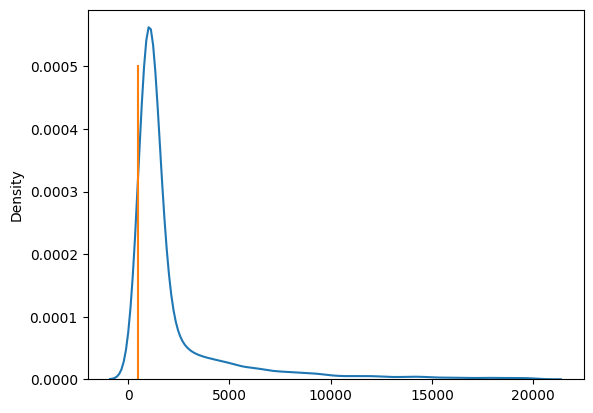

In [258]:
sns.kdeplot(ncounts)
plt.plot([500, 500], [0, 0.0005])